In [ ]:
##imports
import time
import numpy as np
import sys
import random
import os
import warnings
import datetime
import argparse

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.utils.data.distributed
from easydict import EasyDict as edict
from tqdm import tqdm

sys.path.append('./')

from data_process.ttnet_dataloader import create_train_val_dataloader, create_test_dataloader
from models.model_utils import create_model, load_pretrained_model, make_data_parallel, resume_model, get_num_parameters
from models.model_utils import freeze_model
from utils.train_utils import create_optimizer, create_lr_scheduler, get_saved_state, save_checkpoint
from utils.train_utils import reduce_tensor, to_python_float
from utils.misc import AverageMeter, ProgressMeter
from utils.logger import Logger
#from config.config import parse_configs
from utils.misc import make_folder

###### Config

In [ ]:
def parse_configs():
    parser = argparse.ArgumentParser(description='TTNet Implementation')
    parser.add_argument('--seed', type=int, default=2020, help='re-produce the results with seed random')
    parser.add_argument('--saved_fn', type=str, default='ttnet', metavar='FN', help='The name using for saving logs, models,...')
    ####################################################################
    ##############     Model configs            ###################
    ####################################################################
    parser.add_argument('-a', '--arch', type=str, default='ttnet', metavar='ARCH', help='The name of the model architecture')
    parser.add_argument('--dropout_p', type=float, default=0.5, metavar='P', help='The dropout probability of the model')
    parser.add_argument('--multitask_learning', action='store_true', help='If true, the weights of different losses will be learnt (train).'
                             'If false, a regular sum of different losses will be applied')
    parser.add_argument('--no_local', action='store_true', help='If true, no local stage for ball detection.')
    parser.add_argument('--no_event', action='store_true', help='If true, no event spotting detection.')
    parser.add_argument('--no_seg', action='store_true', help='If true, no segmentation module.')
    parser.add_argument('--pretrained_path', type=str, default=None, metavar='PATH', help='the path of the pretrained checkpoint')
    parser.add_argument('--overwrite_global_2_local', action='store_true', help='If true, the weights of the local stage will be overwritten by the global stage.')

    ####################################################################
    ##############     Dataloader and Running configs            #######
    ####################################################################
    parser.add_argument('--working-dir', type=str, default='../../', metavar='PATH', help='the ROOT working directory')
    parser.add_argument('--no-val', action='store_true', help='If true, use all data for training, no validation set')
    parser.add_argument('--no-test', action='store_true', help='If true, dont evaluate the model on the test set')
    parser.add_argument('--val-size', type=float, default=0.2, help='The size of validation set')
    parser.add_argument('--smooth-labelling', action='store_true', help='If true, smoothly make the labels of event spotting')
    parser.add_argument('--num_samples', type=int, default=None, help='Take a subset of the dataset to run and debug')
    parser.add_argument('--num_workers', type=int, default=4, help='Number of threads for loading data')
    parser.add_argument('--batch_size', type=int, default=8, help='mini-batch size (default: 8), this is the total'
                             'batch size of all GPUs on the current node when using'
                             'Data Parallel or Distributed Data Parallel')
    parser.add_argument('--print_freq', type=int, default=50, metavar='N', help='print frequency (default: 50)')
    parser.add_argument('--checkpoint_freq', type=int, default=2, metavar='N', help='frequency of saving checkpoints (default: 2)')
    parser.add_argument('--sigma', type=float, default=1., metavar='SIGMA', help='standard deviation of the 1D Gaussian for the ball position target')
    parser.add_argument('--thresh_ball_pos_mask', type=float, default=0.05, metavar='THRESH', help='the lower thresh for the 1D Gaussian of the ball position target')
    ####################################################################
    ##############     Training strategy            ###################
    ####################################################################

    parser.add_argument('--start_epoch', type=int, default=1, metavar='N', help='the starting epoch')
    parser.add_argument('--num_epochs', type=int, default=30, metavar='N', help='number of total epochs to run')
    parser.add_argument('--lr', type=float, default=1e-3, metavar='LR', help='initial learning rate')
    parser.add_argument('--minimum_lr', type=float, default=1e-7, metavar='MIN_LR', help='minimum learning rate during training')
    parser.add_argument('--momentum', type=float, default=0.9, metavar='M', help='momentum')
    parser.add_argument('-wd', '--weight_decay', type=float, default=0., metavar='WD', help='weight decay (default: 1e-6)')
    parser.add_argument('--optimizer_type', type=str, default='adam', metavar='OPTIMIZER', help='the type of optimizer, it can be sgd or adam')
    parser.add_argument('--lr_type', type=str, default='plateau', metavar='SCHEDULER', help='the type of the learning rate scheduler (steplr or ReduceonPlateau)')
    parser.add_argument('--lr_factor', type=float, default=0.5, metavar='FACTOR', help='reduce the learning rate with this factor')
    parser.add_argument('--lr_step_size', type=int, default=5, metavar='STEP_SIZE', help='step_size of the learning rate when using steplr scheduler')
    parser.add_argument('--lr_patience', type=int, default=3, metavar='N', help='patience of the learning rate when using ReduceoPlateau scheduler')
    parser.add_argument('--earlystop_patience', type=int, default=None, metavar='N', help='Early stopping the training process if performance is not improved within this value')
    parser.add_argument('--freeze_global', action='store_true', help='If true, no update/train weights for the global stage of ball detection.')
    parser.add_argument('--freeze_local', action='store_true', help='If true, no update/train weights for the local stage of ball detection.')
    parser.add_argument('--freeze_event', action='store_true', help='If true, no update/train weights for the event module.')
    parser.add_argument('--freeze_seg', action='store_true', help='If true, no update/train weights for the segmentation module.')

    ####################################################################
    ##############     Loss weight            ###################
    ####################################################################
    parser.add_argument('--bce_weight', type=float, default=0.5, help='The weight of BCE loss in segmentation module, the dice_loss weight = 1- bce_weight')
    parser.add_argument('--global_weight', type=float, default=1., help='The weight of loss of the global stage for ball detection')
    parser.add_argument('--local_weight', type=float, default=1., help='The weight of loss of the local stage for ball detection')
    parser.add_argument('--event_weight', type=float, default=1., help='The weight of loss of the event spotting module')
    parser.add_argument('--seg_weight', type=float, default=1., help='The weight of BCE loss in segmentation module')

    ####################################################################
    ##############     Distributed Data Parallel            ############
    ####################################################################
    parser.add_argument('--world-size', default=-1, type=int, metavar='N', help='number of nodes for distributed training')
    parser.add_argument('--rank', default=-1, type=int, metavar='N', help='node rank for distributed training')
    parser.add_argument('--dist-url', default='tcp://127.0.0.1:29500', type=str, help='url used to set up distributed training')
    parser.add_argument('--dist-backend', default='nccl', type=str, help='distributed backend')
    parser.add_argument('--gpu_idx', default=0, type=int, help='GPU index to use.')
    parser.add_argument('--no_cuda', action='store_true', help='If true, cuda is not used.')
    parser.add_argument('--multiprocessing-distributed', action='store_true', help='Use multi-processing distributed training to launch '
                             'N processes per node, which has N GPUs. This is the '
                             'fastest way to use PyTorch for either single node or '
                             'multi node data parallel training')
    ####################################################################
    ##############     Evaluation configurations     ###################
    ####################################################################
    parser.add_argument('--evaluate', action='store_true', help='only evaluate the model, not training')
    parser.add_argument('--resume_path', type=str, default=None, metavar='PATH', help='the path of the resumed checkpoint')
    parser.add_argument('--use_best_checkpoint', action='store_true', help='If true, choose the best model on val set, otherwise choose the last model')
    parser.add_argument('--seg_thresh', type=float, default=0.5, help='threshold of the segmentation output')
    parser.add_argument('--event_thresh', type=float, default=0.5, help='threshold of the event spotting output')
    parser.add_argument('--save_test_output', action='store_true', help='If true, the image of testing phase will be saved')

    ####################################################################
    ##############     Demonstration configurations     ###################
    ####################################################################
    parser.add_argument('--video_path', type=str, default=None, metavar='PATH', help='the path of the video that needs to demo')
    parser.add_argument('--output_format', type=str, default='text', metavar='PATH', help='the type of the demo output')
    parser.add_argument('--show_image', action='store_true', help='If true, show the image during demostration')
    parser.add_argument('--save_demo_output', action='store_true', help='If true, the image of demonstration phase will be saved')

    configs = edict(vars(parser.parse_args([])))

    return configs

In [ ]:
def config_process(configs):
    ####################################################################
    ############## Hardware configurations ############################
    ####################################################################
    configs.device = torch.device('cpu' if configs.no_cuda else 'cuda')
    configs.ngpus_per_node = torch.cuda.device_count()

    configs.pin_memory = True

    ####################################################################
    ##############     Data configs            ###################
    ####################################################################
    configs.dataset_dir = os.path.join(configs.working_dir, 'dataset')
    configs.train_game_list = ['game_1']#, 'game_2', 'game_3', 'game_4', 'game_5']
    configs.test_game_list = ['test_1']#, 'test_2', 'test_3', 'test_4', 'test_5', 'test_6', 'test_7']
    configs.events_dict = {
        'bounce': 0,
        'net': 1,
        'empty_event': 2
    }
    configs.events_weights_loss_dict = {
        'bounce': 1.,
        'net': 3.,
    }
    configs.events_weights_loss = (configs.events_weights_loss_dict['bounce'], configs.events_weights_loss_dict['net'])
    configs.num_events = len(configs.events_weights_loss_dict)  # Just "bounce" and "net hits"
    configs.num_frames_sequence = 9

    configs.org_size = (1920, 1080)
    configs.input_size = (320, 128)

    configs.tasks = ['global', 'local', 'event', 'seg']
    if configs.no_local:
        if 'local' in configs.tasks:
            configs.tasks.remove('local')
        if 'event' in configs.tasks:
            configs.tasks.remove('event')
    if configs.no_event:
        if 'event' in configs.tasks:
            configs.tasks.remove('event')
    if configs.no_seg:
        if 'seg' in configs.tasks:
            configs.tasks.remove('seg')

    # Compose loss weight for tasks, normalize the weights later
    loss_weight_dict = {
        'global': configs.global_weight,
        'local': configs.local_weight,
        'event': configs.event_weight,
        'seg': configs.seg_weight
    }
    configs.tasks_loss_weight = [loss_weight_dict[task] for task in configs.tasks]

    configs.freeze_modules_list = []
    if configs.freeze_global:
        configs.freeze_modules_list.append('ball_global_stage')
    if configs.freeze_local:
        configs.freeze_modules_list.append('ball_local_stage')
    if configs.freeze_event:
        configs.freeze_modules_list.append('events_spotting')
    if configs.freeze_seg:
        configs.freeze_modules_list.append('segmentation')

    ####################################################################
    ############## logs, Checkpoints, and results dir ########################
    ####################################################################
    configs.checkpoints_dir = os.path.join(configs.working_dir, 'checkpoints', configs.saved_fn)
    configs.logs_dir = os.path.join(configs.working_dir, 'logs', configs.saved_fn)
    configs.use_best_checkpoint = True

    if configs.use_best_checkpoint:
        configs.saved_weight_name = os.path.join(configs.checkpoints_dir, '{}_best.pth'.format(configs.saved_fn))
    else:
        configs.saved_weight_name = os.path.join(configs.checkpoints_dir, '{}.pth'.format(configs.saved_fn))

    configs.results_dir = os.path.join(configs.working_dir, 'results')

    make_folder(configs.checkpoints_dir)
    make_folder(configs.logs_dir)
    make_folder(configs.results_dir)

    if configs.save_test_output:
        configs.saved_dir = os.path.join(configs.results_dir, configs.saved_fn)
        make_folder(configs.saved_dir)

    if configs.save_demo_output:
        configs.save_demo_dir = os.path.join(configs.results_dir, 'demo', configs.saved_fn)
        make_folder(configs.save_demo_dir)

    return configs

In [ ]:
PHASE = 1

In [ ]:
configs = parse_configs()

In [ ]:
if PHASE == 1: 
    #Phase 1
    configs.working_dir      = "../"
    configs.saved_fn         = 'ttnet_1st_phase_opentt_custom'
    configs.no_val           = True
    configs.batch_size       = 24
    configs.num_workers      = 8
    configs.lr               = 0.001 
    configs.lr_type          = 'step_lr' 
    configs.lr_step_size     = 10 
    configs.lr_factor        = 0.1
    configs.gpu_idx          = 0 
    configs.global_weight    = 5. 
    configs.seg_weight       = 1.
    configs.no_event         = True
    configs.no_local         = True
    configs.print_freq       = 500
    configs.smooth_labelling = True

if PHASE == 2:
    #Phase 2
    configs.working_dir                = "../"
    configs.batch_size                 = 24
    configs.num_workers                = 8
    configs.saved_fn                   = 'ttnet_2nd_phase_wtt' 
    configs.no_val                     = True  
    configs.lr                         = 0.001 
    configs.lr_type                    = 'step_lr' 
    configs.lr_step_size               =  10 
    configs.lr_factor                  = 0.1 
    configs.gpu_idx                    = 0 
    configs.global_weight              = 0. 
    configs.event_weight               = 2. 
    configs.local_weight               = 1. 
    configs.pretrained_path            = "../../checkpoints/ttnet/ttnet_1st_phase_wtt_epoch_30.pth"
    configs.overwrite_global_2_local   = True
    configs.freeze_global              = True
    configs.smooth_labelling           = True
    configs.freeze_seg                 = True
    configs.sigma                      =  1.0
    configs.print_freq                 =  500   
    
if PHASE == 3:
    #Phase 3
    configs.working_dir       = "../"
    configs.saved_fn          = 'ttnet_3nd_phase' 
    configs.batch_size        = 24
    configs.num_workers       = 8
    
    configs.no_val            = True  
    configs.lr                = 0.0001 
    configs.lr_type           = 'step_lr' 
    configs.lr_step_size      =  10 
    configs.lr_factor         = 0.2 
    configs.gpu_idx           = 0 
    configs.global_weight     = 1. 
    configs.event_weight      = 1. 
    configs.local_weight      = 1. 
    configs.pretrained_path   = "../../checkpoints/ttnet/ttnet_2nd_phase_epoch_30.pth"
    configs.smooth_labelling  = True
#     configs.sigma             = 1.0
    configs.print_freq        = 500

In [ ]:
configs = config_process(configs)

In [ ]:
configs.freeze_modules_list

In [ ]:
if configs.seed is not None:
    random.seed(configs.seed)
    np.random.seed(configs.seed)
    torch.manual_seed(configs.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
if configs.gpu_idx is not None:
    warnings.warn('You have chosen a specific GPU. This will completely '
                      'disable data parallelism.')

In [ ]:
configs.distributed = configs.world_size > 1 or configs.multiprocessing_distributed

In [ ]:
if configs.gpu_idx is not None:
    print("Use GPU: {} for training".format(configs.gpu_idx))
    configs.device = torch.device('cuda:{}'.format(configs.gpu_idx))

In [ ]:
configs.is_master_node = (not configs.distributed) or (configs.distributed and (configs.rank % configs.ngpus_per_node == 0))

In [ ]:
configs.is_master_node

In [ ]:
if configs.is_master_node:
    logger = Logger(configs.logs_dir, configs.saved_fn)
    logger.info('>>> Created a new logger')
    logger.info('>>> configs: {}'.format(configs))
    tb_writer = SummaryWriter(log_dir=os.path.join(configs.logs_dir, 'tensorboard'))
else:
    logger = None
    tb_writer = None

##### Model creation

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.maxpool(self.relu(self.batchnorm(self.conv(x))))
        return x
class ConvBlock_without_Pooling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock_without_Pooling, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.batchnorm(self.conv(x)))
        return x
class DeconvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DeconvBlock, self).__init__()
        middle_channels = int(in_channels / 4)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, kernel_size=1, stride=1, padding=0)
        self.batchnorm1 = nn.BatchNorm2d(middle_channels)
        self.relu = nn.ReLU()
        self.batchnorm_tconv = nn.BatchNorm2d(middle_channels)
        self.tconv = nn.ConvTranspose2d(middle_channels, middle_channels, kernel_size=3, stride=2, padding=1,
                                        output_padding=1)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batchnorm2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.relu(self.batchnorm1(self.conv1(x)))
        x = self.relu(self.batchnorm_tconv(self.tconv(x)))
        x = self.relu(self.batchnorm2(self.conv2(x)))

        return x
class BallDetection(nn.Module):
    def __init__(self, num_frames_sequence, dropout_p):
        super(BallDetection, self).__init__()
        self.conv1 = nn.Conv2d(num_frames_sequence * 3, 64, kernel_size=1, stride=1, padding=0)
        self.batchnorm = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.convblock1 = ConvBlock(in_channels=64, out_channels=64)
        self.convblock2 = ConvBlock(in_channels=64, out_channels=64)
        self.dropout2d = nn.Dropout2d(p=dropout_p)
        self.convblock3 = ConvBlock(in_channels=64, out_channels=128)
        self.convblock4 = ConvBlock(in_channels=128, out_channels=128)
        self.convblock5 = ConvBlock(in_channels=128, out_channels=256)
        self.convblock6 = ConvBlock(in_channels=256, out_channels=256)
        self.fc1 = nn.Linear(in_features=2560, out_features=1792)
        self.fc2 = nn.Linear(in_features=1792, out_features=896)
        self.fc3 = nn.Linear(in_features=896, out_features=448)
        self.dropout1d = nn.Dropout(p=dropout_p)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.batchnorm(self.conv1(x)))
        out_block2 = self.convblock2(self.convblock1(x))
        x = self.dropout2d(out_block2)
        out_block3 = self.convblock3(x)
        out_block4 = self.convblock4(out_block3)
        x = self.dropout2d(out_block4)
        out_block5 = self.convblock5(out_block4)
        features = self.convblock6(out_block5)

        x = self.dropout2d(features)
        x = x.contiguous().view(x.size(0), -1)

        x = self.dropout1d(self.relu(self.fc1(x)))
        x = self.dropout1d(self.relu(self.fc2(x)))
        out = self.sigmoid(self.fc3(x))

        return out, features, out_block2, out_block3, out_block4, out_block5
class EventsSpotting(nn.Module):
    def __init__(self, dropout_p):
        super(EventsSpotting, self).__init__()
        self.conv1 = nn.Conv2d(512, 64, kernel_size=1, stride=1, padding=0)
        self.batchnorm = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.dropout2d = nn.Dropout2d(p=dropout_p)
        self.convblock = ConvBlock_without_Pooling(in_channels=64, out_channels=64)
        self.fc1 = nn.Linear(in_features=640, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, global_features, local_features):
        input_eventspotting = torch.cat((global_features, local_features), dim=1)
        x = self.relu(self.batchnorm(self.conv1(input_eventspotting)))
        x = self.dropout2d(x)
        x = self.convblock(x)
        x = self.dropout2d(x)
        x = self.convblock(x)
        x = self.dropout2d(x)

        x = x.contiguous().view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        out = self.sigmoid(self.fc2(x))

        return out
class Segmentation(nn.Module):
    def __init__(self):
        super(Segmentation, self).__init__()
        self.deconvblock5 = DeconvBlock(in_channels=256, out_channels=128)
        self.deconvblock4 = DeconvBlock(in_channels=128, out_channels=128)
        self.deconvblock3 = DeconvBlock(in_channels=128, out_channels=64)
        self.deconvblock2 = DeconvBlock(in_channels=64, out_channels=64)
        self.tconv = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=0,
                                        output_padding=0)
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 3, kernel_size=2, stride=1, padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, out_block2, out_block3, out_block4, out_block5):
        x = self.deconvblock5(out_block5)
        x = x + out_block4
        x = self.deconvblock4(x)
        x = x + out_block3
        x = self.deconvblock3(x)

        x = x + out_block2
        x = self.deconvblock2(x)

        x = self.relu(self.tconv(x))

        x = self.relu(self.conv1(x))

        out = self.sigmoid(self.conv2(x))

        return out
class TTNet(nn.Module):
    def __init__(self, dropout_p, tasks, input_size, thresh_ball_pos_mask, num_frames_sequence,
                 mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        super(TTNet, self).__init__()
        self.tasks = tasks
        self.ball_local_stage, self.events_spotting, self.segmentation = None, None, None
        self.ball_global_stage = BallDetection(num_frames_sequence=num_frames_sequence, dropout_p=dropout_p)
        if 'local' in tasks:
            self.ball_local_stage = BallDetection(num_frames_sequence=num_frames_sequence, dropout_p=dropout_p)
        if 'event' in tasks:
            self.events_spotting = EventsSpotting(dropout_p=dropout_p)
        if 'seg' in tasks:
            self.segmentation = Segmentation()
        self.w_resize = input_size[0]
        self.h_resize = input_size[1]
        self.thresh_ball_pos_mask = thresh_ball_pos_mask
        self.mean = torch.repeat_interleave(torch.tensor(mean).view(1, 3, 1, 1), repeats=9, dim=1)
        self.std = torch.repeat_interleave(torch.tensor(std).view(1, 3, 1, 1), repeats=9, dim=1)

    def forward(self, resize_batch_input, org_ball_pos_xy):
        """Forward propagation
        :param resize_batch_input: (batch_size, 27, 128, 320)
        :param org_ball_pos_xy: (batch_size, 2) --> Use it to get ground-truth for the local stage
        :return:
        """
        pred_ball_local, pred_events, pred_seg, local_ball_pos_xy = None, None, None, None

        # Normalize the input before compute forward propagation
        pred_ball_global, global_features, out_block2, out_block3, out_block4, out_block5 = self.ball_global_stage(
            self.__normalize__(resize_batch_input))
        if self.ball_local_stage is not None:
            # Based on the prediction of the global stage, crop the original images
            input_ball_local, cropped_params = self.__crop_original_batch__(resize_batch_input, pred_ball_global)
            # Get the ground truth of the ball for the local stage
            local_ball_pos_xy = self.__get_groundtruth_local_ball_pos__(org_ball_pos_xy, cropped_params)
            # Normalize the input before compute forward propagation
            pred_ball_local, local_features, *_ = self.ball_local_stage(self.__normalize__(input_ball_local))
            # Only consider the events spotting if the model has the local stage for ball detection
            if self.events_spotting is not None:
                pred_events = self.events_spotting(global_features, local_features)
        if self.segmentation is not None:
            pred_seg = self.segmentation(out_block2, out_block3, out_block4, out_block5)

        return pred_ball_global, pred_ball_local, pred_events, pred_seg, local_ball_pos_xy

    def run_demo(self, resize_batch_input):
        """Only for full 4 stages/modules in TTNet"""

        # Normalize the input before compute forward propagation
        pred_ball_global, global_features, out_block2, out_block3, out_block4, out_block5 = self.ball_global_stage(
            self.__normalize__(resize_batch_input))
        input_ball_local, cropped_params = self.__crop_original_batch__(resize_batch_input, pred_ball_global)
        # Normalize the input before compute forward propagation
        pred_ball_local, local_features, *_ = self.ball_local_stage(self.__normalize__(input_ball_local))
        pred_events = self.events_spotting(global_features, local_features)
        pred_seg = self.segmentation(out_block2, out_block3, out_block4, out_block5)

        return pred_ball_global, pred_ball_local, pred_events, pred_seg

    def __normalize__(self, x):
        if not self.mean.is_cuda:
            self.mean = self.mean.cuda()
            self.std = self.std.cuda()

        return (x / 255. - self.mean) / self.std

    def __get_groundtruth_local_ball_pos__(self, org_ball_pos_xy, cropped_params):
        local_ball_pos_xy = torch.zeros_like(org_ball_pos_xy)  # no grad for torch.zeros_like output

        for idx, params in enumerate(cropped_params):
            is_ball_detected, x_min, x_max, y_min, y_max, x_pad, y_pad = params

            if is_ball_detected:
                # Get the local ball position based on the crop image informaion
                local_ball_pos_xy[idx, 0] = max(org_ball_pos_xy[idx, 0] - x_min + x_pad, -1)
                local_ball_pos_xy[idx, 1] = max(org_ball_pos_xy[idx, 1] - y_min + y_pad, -1)
                # If the ball is outside of the cropped image --> set position to -1, -1 --> No ball
                if (local_ball_pos_xy[idx, 0] >= self.w_resize) or (local_ball_pos_xy[idx, 1] >= self.h_resize) or (
                        local_ball_pos_xy[idx, 0] < 0) or (local_ball_pos_xy[idx, 1] < 0):
                    local_ball_pos_xy[idx, 0] = -1
                    local_ball_pos_xy[idx, 1] = -1
            else:
                local_ball_pos_xy[idx, 0] = -1
                local_ball_pos_xy[idx, 1] = -1
        return local_ball_pos_xy

    def __crop_original_batch__(self, resize_batch_input, pred_ball_global):
        """Get input of the local stage by cropping the original images based on the predicted ball position
            of the global stage
        :param resize_batch_input: (batch_size, 27, 128, 320)
        :param pred_ball_global: (batch_size, 448)
        :param org_ball_pos_xy: (batch_size, 2)
        :return: input_ball_local (batch_size, 27, 128, 320)
        """
        # Process input for local stage based on output of the global one

        batch_size = resize_batch_input.size(0)
        h_original, w_original = 1080, 1920
        h_ratio = h_original / self.h_resize
        w_ratio = w_original / self.w_resize
        pred_ball_global_mask = pred_ball_global.clone().detach()
        pred_ball_global_mask[pred_ball_global_mask < self.thresh_ball_pos_mask] = 0.

        # Crop the original images
        input_ball_local = torch.zeros_like(resize_batch_input)  # same shape with resize_batch_input, no grad
        original_batch_input = F.interpolate(resize_batch_input, (h_original, w_original))  # On GPU
        cropped_params = []
        for idx in range(batch_size):
            pred_ball_pos_x = pred_ball_global_mask[idx, :self.w_resize]
            pred_ball_pos_y = pred_ball_global_mask[idx, self.w_resize:]
            # If the ball is not detected, we crop the center of the images, set ball_poss to [-1, -1]
            if (torch.sum(pred_ball_pos_x) == 0.) or (torch.sum(pred_ball_pos_y) == 0.):
                # Assume the ball is in the center image
                x_center = int(self.w_resize / 2)
                y_center = int(self.h_resize / 2)
                is_ball_detected = False
            else:
                x_center = torch.argmax(pred_ball_pos_x)  # Upper part
                y_center = torch.argmax(pred_ball_pos_y)  # Lower part
                is_ball_detected = True

            # Adjust ball position to the original size
            x_center = int(x_center * w_ratio)
            y_center = int(y_center * h_ratio)

            x_min, x_max, y_min, y_max = self.__get_crop_params__(x_center, y_center, self.w_resize, self.h_resize,
                                                                  w_original, h_original)
            # Put image to the center
            h_crop = y_max - y_min
            w_crop = x_max - x_min
            x_pad = 0
            y_pad = 0
            if (h_crop != self.h_resize) or (w_crop != self.w_resize):
                x_pad = int((self.w_resize - w_crop) / 2)
                y_pad = int((self.h_resize - h_crop) / 2)
                input_ball_local[idx, :, y_pad:(y_pad + h_crop), x_pad:(x_pad + w_crop)] = original_batch_input[idx, :,
                                                                                           y_min:y_max, x_min: x_max]
            else:
                input_ball_local[idx, :, :, :] = original_batch_input[idx, :, y_min:y_max, x_min: x_max]
            cropped_params.append([is_ball_detected, x_min, x_max, y_min, y_max, x_pad, y_pad])

        return input_ball_local, cropped_params

    def __get_crop_params__(self, x_center, y_center, w_resize, h_resize, w_original, h_original):
        x_min = max(0, x_center - int(w_resize / 2))
        y_min = max(0, y_center - int(h_resize / 2))

        x_max = min(w_original, x_min + w_resize)
        y_max = min(h_original, y_min + h_resize)

        return x_min, x_max, y_min, y_max

In [ ]:
configs.tasks

In [ ]:
def check_ttnet(configs):
    ttnet = TTNet(dropout_p=0.5, tasks=configs.tasks, input_size=(320, 128), thresh_ball_pos_mask=0.01,
                  num_frames_sequence=9).cuda()
    resize_batch_input = torch.rand((1, 27, 128, 320)).cuda()
    org_ball_pos_xy = torch.rand((1, 2)).cuda()
    start = time.time()
    
#     pred_ball_global, pred_ball_local, pred_events, local_ball_pos_xy = ttnet(resize_batch_input, org_ball_pos_xy)
    pred_ball_global, pred_ball_local, pred_events, pred_seg, local_ball_pos_xy = ttnet(resize_batch_input, org_ball_pos_xy)
    
#     print("DEBUG Unbalaced loss: ", pred_ball_global.shape, pred_ball_local.shape, pred_events.shape, local_ball_pos_xy.shape)    
        
    if pred_ball_global is not None:
        print('pred_ball_global: {}'.format(pred_ball_global.size()))
    if pred_ball_local is not None:
        print('pred_ball_local: {}'.format(pred_ball_local.size()))
    if pred_events is not None:
        print('pred_events: {}'.format(pred_events.size()))
    if pred_seg is not None:
        print('Seg_events: {}'.format(pred_seg.size()))
#     print('local_ball_pos_xy: {}'.format(local_ball_pos_xy.size()))
    return ttnet

In [ ]:
test_model = check_ttnet(configs)

In [ ]:
model = create_model(configs)

In [ ]:
model = make_data_parallel(model, configs)

model = freeze_model(model, configs.freeze_modules_list)

#### Losses

In [ ]:
class Ball_Detection_Loss(nn.Module):
    def __init__(self, w, h, epsilon=1e-9):
        super(Ball_Detection_Loss, self).__init__()
        self.w = w
        self.h = h
        self.epsilon = epsilon
        self.criterion = nn.KLDivLoss(reduction="batchmean")

    def forward(self, pred_ball_position, target_ball_position):
        x_pred = pred_ball_position[:, :self.w]
        y_pred = pred_ball_position[:, self.w:]

        x_target = target_ball_position[:, :self.w]
        y_target = target_ball_position[:, self.w:]

        loss_ball_x = - torch.mean(x_target * torch.log(x_pred + self.epsilon) + (1 - x_target) * torch.log(1 - x_pred + self.epsilon))
        loss_ball_y = - torch.mean(y_target * torch.log(y_pred + self.epsilon) + (1 - y_target) * torch.log(1 - y_pred + self.epsilon))
#         loss_ball_x = self.criterion(x_target.log(), x_pred)
#         loss_ball_y = self.criterion(y_target.log(), y_pred)
        
        return loss_ball_x + loss_ball_y

In [ ]:
class Events_Spotting_Loss(nn.Module):
    def __init__(self, weights=(1, 3), num_events=2, epsilon=1e-9):
        super(Events_Spotting_Loss, self).__init__()
        self.weights = torch.tensor(weights).view(1, 2)
        self.weights = self.weights / self.weights.sum()
        self.num_events = num_events
        self.epsilon = epsilon

    def forward(self, pred_events, target_events):
        self.weights = self.weights.cuda()
        return - torch.mean(self.weights * (target_events * torch.log(pred_events + self.epsilon) + (1. - target_events) * torch.log(1 - pred_events + self.epsilon)))
class DICE_Smotth_Loss(nn.Module):
    def __init__(self, epsilon=1e-9):
        super(DICE_Smotth_Loss, self).__init__()
        self.epsilon = epsilon

    def forward(self, pred_seg, target_seg):
        return 1. - ((torch.sum(2 * pred_seg * target_seg) + self.epsilon) / (torch.sum(pred_seg) + torch.sum(target_seg) + self.epsilon))
class BCE_Loss(nn.Module):
    def __init__(self, epsilon=1e-9):
        super(BCE_Loss, self).__init__()
        self.epsilon = epsilon

    def forward(self, pred_seg, target_seg):
        return - torch.mean(target_seg * torch.log(pred_seg + self.epsilon) + (1 - target_seg) * torch.log(1 - pred_seg + self.epsilon))
class Segmentation_Loss(nn.Module):
    def __init__(self, bce_weight=0.5):
        super(Segmentation_Loss, self).__init__()
        self.bce_criterion = BCE_Loss(epsilon=1e-9)
        self.dice_criterion = DICE_Smotth_Loss(epsilon=1e-9)
        self.bce_weight = bce_weight

    def forward(self, pred_seg, target_seg):
        target_seg = target_seg.float()
        loss_bce = self.bce_criterion(pred_seg, target_seg)
        loss_dice = self.dice_criterion(pred_seg, target_seg)
        loss_seg = (1 - self.bce_weight) * loss_dice + self.bce_weight * loss_bce
        return loss_seg

In [ ]:
class DICE_Smotth_Loss(nn.Module):
    def __init__(self, epsilon=1e-9):
        super(DICE_Smotth_Loss, self).__init__()
        self.epsilon = epsilon

    def forward(self, pred_seg, target_seg):
        return 1. - ((torch.sum(2 * pred_seg * target_seg) + self.epsilon) / (torch.sum(pred_seg) + torch.sum(target_seg) + self.epsilon))

In [ ]:
class BCE_Loss(nn.Module):
    def __init__(self, epsilon=1e-9):
        super(BCE_Loss, self).__init__()
        self.epsilon = epsilon

    def forward(self, pred_seg, target_seg):
        return - torch.mean(target_seg * torch.log(pred_seg + self.epsilon) + (1 - target_seg) * torch.log(1 - pred_seg + self.epsilon))

In [ ]:
class Segmentation_Loss(nn.Module):
    def __init__(self, bce_weight=0.5):
        super(Segmentation_Loss, self).__init__()
        self.bce_criterion = BCE_Loss(epsilon=1e-9)
        self.dice_criterion = DICE_Smotth_Loss(epsilon=1e-9)
        self.bce_weight = bce_weight

    def forward(self, pred_seg, target_seg):
        target_seg = target_seg.float()
        loss_bce = self.bce_criterion(pred_seg, target_seg)
        loss_dice = self.dice_criterion(pred_seg, target_seg)
        loss_seg = (1 - self.bce_weight) * loss_dice + self.bce_weight * loss_bce
        return loss_seg

In [ ]:
class Unbalance_Loss_Model(nn.Module):
    def __init__(self, model, tasks_loss_weight, weights_events, input_size, sigma, thresh_ball_pos_mask, device):
        super(Unbalance_Loss_Model, self).__init__()
        self.model = model
        self.tasks_loss_weight = torch.tensor(tasks_loss_weight)
        self.tasks_loss_weight = self.tasks_loss_weight / self.tasks_loss_weight.sum()
        self.num_events = len(tasks_loss_weight)
        self.w = input_size[0]
        self.h = input_size[1]
        self.sigma = sigma
        self.thresh_ball_pos_mask = thresh_ball_pos_mask
        self.device = device
        self.ball_loss_criterion = Ball_Detection_Loss(self.w, self.h)
        self.event_loss_criterion = Events_Spotting_Loss(weights=weights_events, num_events=self.num_events)
        self.seg_loss_criterion = Segmentation_Loss()

    def forward(self, resize_batch_input, org_ball_pos_xy, global_ball_pos_xy, target_events, target_seg):
        pred_ball_global, pred_ball_local, pred_events, pred_seg, local_ball_pos_xy = self.model(resize_batch_input,
                                                                                                 org_ball_pos_xy)
        # Create target for events spotting and ball position (local and global)
        batch_size = pred_ball_global.size(0)
        target_ball_global = torch.zeros_like(pred_ball_global)
        task_idx = 0
        for sample_idx in range(batch_size):
            target_ball_global[sample_idx] = create_target_ball(global_ball_pos_xy[sample_idx], sigma=self.sigma,
                                                                w=self.w, h=self.h,
                                                                thresh_mask=self.thresh_ball_pos_mask,
                                                                device=self.device)
        global_ball_loss = self.ball_loss_criterion(pred_ball_global, target_ball_global)
        total_loss = global_ball_loss * self.tasks_loss_weight[task_idx]

        if pred_ball_local is not None:
            task_idx += 1
            target_ball_local = torch.zeros_like(pred_ball_local)
            for sample_idx in range(batch_size):
                target_ball_local[sample_idx] = create_target_ball(local_ball_pos_xy[sample_idx], sigma=self.sigma,
                                                                   w=self.w, h=self.h,
                                                                   thresh_mask=self.thresh_ball_pos_mask,
                                                                   device=self.device)
            local_ball_loss = self.ball_loss_criterion(pred_ball_local, target_ball_local)
            total_loss += local_ball_loss * self.tasks_loss_weight[task_idx]

        if pred_events is not None:
            task_idx += 1
            target_events = target_events.to(device=self.device)
            event_loss = self.event_loss_criterion(pred_events, target_events)
            total_loss += event_loss * self.tasks_loss_weight[task_idx]

        if pred_seg is not None:
            task_idx += 1
            seg_loss = self.seg_loss_criterion(pred_seg, target_seg)
            total_loss += seg_loss * self.tasks_loss_weight[task_idx]

        return pred_ball_global, pred_ball_local, pred_events, pred_seg, local_ball_pos_xy, total_loss, None

    def run_demo(self, resize_batch_input):
        pred_ball_global, pred_ball_local, pred_events, pred_seg = self.model.run_demo(resize_batch_input)
        return pred_ball_global, pred_ball_local, pred_events, pred_seg

In [ ]:
class Multi_Task_Learning_Model(nn.Module):
    """
    Original paper: "Multi-task learning using uncertainty to weigh losses for scene geometry and semantics" - CVPR 2018
    url: https://arxiv.org/pdf/1705.07115.pdf
    refer code: https://github.com/Hui-Li/multi-task-learning-example-PyTorch
    """

    def __init__(self, model, tasks, num_events, weights_events, input_size, sigma, thresh_ball_pos_mask, device):
        super(Multi_Task_Learning_Model, self).__init__()
        self.model = model
        self.tasks = tasks
        self.num_tasks = len(tasks)
        self.log_vars = nn.Parameter(torch.zeros((self.num_tasks)))
        self.w = input_size[0]
        self.h = input_size[1]
        self.sigma = sigma
        self.thresh_ball_pos_mask = thresh_ball_pos_mask
        self.device = device
        self.ball_loss_criterion = Ball_Detection_Loss(self.w, self.h)
        self.event_loss_criterion = Events_Spotting_Loss(weights=weights_events, num_events=num_events)
        self.seg_loss_criterion = Segmentation_Loss()

    def forward(self, resize_batch_input, org_ball_pos_xy, global_ball_pos_xy, target_events, target_seg):
        log_vars_idx = 0
        pred_ball_global, pred_ball_local, pred_events, pred_seg, local_ball_pos_xy = self.model(resize_batch_input,
                                                                                                 org_ball_pos_xy)
        # Create target for events spotting and ball position (local and global)
        batch_size = pred_ball_global.size(0)
        target_ball_global = torch.zeros_like(pred_ball_global)
        for sample_idx in range(batch_size):
            target_ball_global[sample_idx] = create_target_ball(global_ball_pos_xy[sample_idx], sigma=self.sigma,
                                                                w=self.w, h=self.h,
                                                                thresh_mask=self.thresh_ball_pos_mask,
                                                                device=self.device)
        global_ball_loss = self.ball_loss_criterion(pred_ball_global, target_ball_global)
        total_loss = global_ball_loss / (torch.exp(2 * self.log_vars[log_vars_idx])) + self.log_vars[log_vars_idx]

        if pred_ball_local is not None:
            log_vars_idx += 1
            target_ball_local = torch.zeros_like(pred_ball_local)
            for sample_idx in range(batch_size):
                target_ball_local[sample_idx] = create_target_ball(local_ball_pos_xy[sample_idx], sigma=self.sigma,
                                                                   w=self.w, h=self.h,
                                                                   thresh_mask=self.thresh_ball_pos_mask,
                                                                   device=self.device)
            local_ball_loss = self.ball_loss_criterion(pred_ball_local, target_ball_local)
            total_loss += local_ball_loss / (torch.exp(2 * self.log_vars[log_vars_idx])) + self.log_vars[log_vars_idx]

        if pred_events is not None:
            log_vars_idx += 1
            target_events = target_events.to(device=self.device)
            event_loss = self.event_loss_criterion(pred_events, target_events)
            total_loss += event_loss / (2 * torch.exp(self.log_vars[log_vars_idx])) + self.log_vars[log_vars_idx]

        if pred_seg is not None:
            log_vars_idx += 1
            seg_loss = self.seg_loss_criterion(pred_seg, target_seg)
            total_loss += seg_loss / (2 * torch.exp(self.log_vars[log_vars_idx])) + self.log_vars[log_vars_idx]

        # Final weights: [math.exp(log_var) ** 0.5 for log_var in log_vars]

        return pred_ball_global, pred_ball_local, pred_events, pred_seg, local_ball_pos_xy, total_loss, self.log_vars.data.tolist()

    def run_demo(self, resize_batch_input):
        pred_ball_global, pred_ball_local, pred_events, pred_seg = self.model.run_demo(resize_batch_input)
        return pred_ball_global, pred_ball_local, pred_events, pred_seg

#### Train supports

In [ ]:
if configs.is_master_node:
    num_parameters = get_num_parameters(model)
    logger.info('number of trained parameters of the model: {}'.format(num_parameters))

optimizer = create_optimizer(configs, model)
lr_scheduler = create_lr_scheduler(optimizer, configs)
best_val_loss = np.inf
earlystop_count = 0
is_best = False

In [ ]:
configs.is_master_node

In [ ]:
if configs.pretrained_path is not None:
    model = load_pretrained_model(model, configs.pretrained_path, gpu_idx, configs.overwrite_global_2_local)
    if logger is not None:
        logger.info('loaded pretrained model at {}'.format(configs.pretrained_path))

# optionally resume from a checkpoint
if configs.resume_path is not None:
    checkpoint = resume_model(configs.resume_path, configs.arch, configs.gpu_idx)
    if hasattr(model, 'module'):
        model.module.load_state_dict(checkpoint['state_dict'])
    else:
        model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    best_val_loss = checkpoint['best_val_loss']
    earlystop_count = checkpoint['earlystop_count']
    configs.start_epoch = checkpoint['epoch'] + 1

if logger is not None:
    logger.info(">>> Loading dataset & getting dataloader...")

##### Datalaoder

In [ ]:
train_loader, val_loader, train_sampler = create_train_val_dataloader(configs)
test_loader = create_test_dataloader(configs)

In [ ]:
def train_one_epoch(train_loader, model, optimizer, epoch, configs, logger):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')

    progress = ProgressMeter(len(train_loader), [batch_time, data_time, losses],
                             prefix="Train - Epoch: [{}/{}]".format(epoch, configs.num_epochs))

    # switch to train mode
    model.train()
    start_time = time.time()
    for batch_idx, (resized_imgs, org_ball_pos_xy, global_ball_pos_xy, target_events, target_seg) in enumerate(
            tqdm(train_loader)):
        data_time.update(time.time() - start_time)
        batch_size = resized_imgs.size(0)
        target_seg = target_seg.to(configs.device, non_blocking=True)
        resized_imgs = resized_imgs.to(configs.device, non_blocking=True).float()
        pred_ball_global, pred_ball_local, pred_events, pred_seg, local_ball_pos_xy, total_loss, _ = model(
            resized_imgs, org_ball_pos_xy, global_ball_pos_xy, target_events, target_seg)
        # For torch.nn.DataParallel case
        if (not configs.distributed) and (configs.gpu_idx is None):
            total_loss = torch.mean(total_loss)

        # zero the parameter gradients
        optimizer.zero_grad()
        # compute gradient and perform backpropagation
        total_loss.backward()
        optimizer.step()

        if configs.distributed:
            reduced_loss = reduce_tensor(total_loss.data, configs.world_size)
        else:
            reduced_loss = total_loss.data
        losses.update(to_python_float(reduced_loss), batch_size)
        # measure elapsed time
        torch.cuda.synchronize()
        batch_time.update(time.time() - start_time)

        # Log message
        if logger is not None:
            if ((batch_idx + 1) % configs.print_freq) == 0:
                logger.info(progress.get_message(batch_idx))

        start_time = time.time()

    return losses.avg

In [ ]:
def evaluate_one_epoch(val_loader, model, epoch, configs, logger):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')

    progress = ProgressMeter(len(val_loader), [batch_time, data_time, losses],
                             prefix="Evaluate - Epoch: [{}/{}]".format(epoch, configs.num_epochs))
    # switch to evaluate mode
    model.eval()
    with torch.no_grad():
        start_time = time.time()
        for batch_idx, (resized_imgs, org_ball_pos_xy, global_ball_pos_xy, target_events, target_seg) in enumerate(
                tqdm(val_loader)):
            data_time.update(time.time() - start_time)
            batch_size = resized_imgs.size(0)
            target_seg = target_seg.to(configs.device, non_blocking=True)
            resized_imgs = resized_imgs.to(configs.device, non_blocking=True).float()
            pred_ball_global, pred_ball_local, pred_events, pred_seg, local_ball_pos_xy, total_loss, _ = model(
                resized_imgs, org_ball_pos_xy, global_ball_pos_xy, target_events, target_seg)

            # For torch.nn.DataParallel case
            if (not configs.distributed) and (configs.gpu_idx is None):
                total_loss = torch.mean(total_loss)

            if configs.distributed:
                reduced_loss = reduce_tensor(total_loss.data, configs.world_size)
            else:
                reduced_loss = total_loss.data
            losses.update(to_python_float(reduced_loss), batch_size)
            # measure elapsed time
            torch.cuda.synchronize()
            batch_time.update(time.time() - start_time)

            # Log message
            if logger is not None:
                if ((batch_idx + 1) % configs.print_freq) == 0:
                    logger.info(progress.get_message(batch_idx))

            start_time = time.time()

    return losses.avg

In [ ]:
if logger is not None:
    logger.info('number of batches in train set: {}'.format(len(train_loader)))
    if val_loader is not None:
        logger.info('number of batches in val set: {}'.format(len(val_loader)))
    logger.info('number of batches in test set: {}'.format(len(test_loader)))

if configs.evaluate:
    assert val_loader is not None, "The validation should not be None"
    val_loss = evaluate_one_epoch(val_loader, model, configs.start_epoch - 1, configs, logger)
    print('Evaluate, val_loss: {}'.format(val_loss))


In [ ]:
# val_loss = evaluate_one_epoch(test_loader, model, configs.start_epoch - 1, configs, logger)
# val_loss

In [ ]:
for epoch in range(configs.start_epoch, configs.num_epochs + 1):
    # Get the current learning rate
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    if logger is not None:
        logger.info('{}'.format('*-' * 40))
        logger.info('{} {}/{} {}'.format('=' * 35, epoch, configs.num_epochs, '=' * 35))
        logger.info('{}'.format('*-' * 40))
        logger.info('>>> Epoch: [{}/{}] learning rate: {:.2e}'.format(epoch, configs.num_epochs, lr))

    if configs.distributed:
        train_sampler.set_epoch(epoch)
    # train for one epoch
    train_loss = train_one_epoch(train_loader, model, optimizer, epoch, configs, logger)
    loss_dict = {'train': train_loss}
    if not configs.no_val:
        val_loss = evaluate_one_epoch(val_loader, model, epoch, configs, logger)
        is_best = val_loss <= best_val_loss
        best_val_loss = min(val_loss, best_val_loss)
        loss_dict['val'] = val_loss

    if not configs.no_test:
        test_loss = evaluate_one_epoch(test_loader, model, epoch, configs, logger)
        loss_dict['test'] = test_loss
    # Write tensorboard
    if tb_writer is not None:
        tb_writer.add_scalars('Loss', loss_dict, epoch)
    # Save checkpoint
    if configs.is_master_node and (is_best or ((epoch % configs.checkpoint_freq) == 0)):
        saved_state = get_saved_state(model, optimizer, lr_scheduler, epoch, configs, best_val_loss,
                                      earlystop_count)
        save_checkpoint(configs.checkpoints_dir, configs.saved_fn, saved_state, is_best, epoch)
    # Check early stop training
    if configs.earlystop_patience is not None:
        earlystop_count = 0 if is_best else (earlystop_count + 1)
        print_string = ' |||\t earlystop_count: {}'.format(earlystop_count)
        if configs.earlystop_patience <= earlystop_count:
            print_string += '\n\t--- Early stopping!!!'
            break
        else:
            print_string += '\n\t--- Continue training..., earlystop_count: {}'.format(earlystop_count)
        if logger is not None:
            logger.info(print_string)
    # Adjust learning rate
    if configs.lr_type == 'plateau':
        assert (not configs.no_val), "Only use plateau when having validation set"
        lr_scheduler.step(val_loss)
    else:
        lr_scheduler.step()



In [ ]:
if tb_writer is not None:
    tb_writer.close()


#### Appendix

##### Loss exp

In [54]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [55]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [56]:
def parse_args():    
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=14, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--no-mps', action='store_true', default=False,
                        help='disables macOS GPU training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args = parser.parse_args([])
    return args

In [57]:
args = parse_args()
use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

if use_cuda:
    device = torch.device("cuda")
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

train_kwargs = {'batch_size': args.batch_size}
test_kwargs = {'batch_size': args.test_batch_size}

In [58]:
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)


In [59]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)

In [60]:
model.train()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [61]:
def main():
    # Training settings
    
    
    
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")


In [62]:





def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))




if __name__ == '__main__':
    main()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.347594
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.983658
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.812437
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.549483
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.719684
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.471002
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.241950
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.357736
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.348226
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.236578
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.295051
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.234309
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.315701
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.230637
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.211834
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.188162
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.150411
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.308384
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.259356
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.248719
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.005156
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.040091
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.042667
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.016043
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.052858
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.009573
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.045211
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.012477
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.111168
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.035781
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.134454
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.038345
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.058406
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.016266
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.021798
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.010563
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.383408
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.026147
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.087794
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.067867


Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.001183
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.124050
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.028677
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.023309
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.000507
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.097581
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.014723
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.020754
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.038414
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.356770
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.088222
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.040106
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.085385
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.101294
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.043066
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.021173
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.080902
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.259819
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.021375
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.029478


Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.013639
Train Epoch: 6 [13440/60000 (22%)]	Loss: 0.004920
Train Epoch: 6 [14080/60000 (23%)]	Loss: 0.050332
Train Epoch: 6 [14720/60000 (25%)]	Loss: 0.050175
Train Epoch: 6 [15360/60000 (26%)]	Loss: 0.058643
Train Epoch: 6 [16000/60000 (27%)]	Loss: 0.013721
Train Epoch: 6 [16640/60000 (28%)]	Loss: 0.051024
Train Epoch: 6 [17280/60000 (29%)]	Loss: 0.004658
Train Epoch: 6 [17920/60000 (30%)]	Loss: 0.017013
Train Epoch: 6 [18560/60000 (31%)]	Loss: 0.035396
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.019837
Train Epoch: 6 [19840/60000 (33%)]	Loss: 0.002271
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.030845
Train Epoch: 6 [21120/60000 (35%)]	Loss: 0.054844
Train Epoch: 6 [21760/60000 (36%)]	Loss: 0.003125
Train Epoch: 6 [22400/60000 (37%)]	Loss: 0.031238
Train Epoch: 6 [23040/60000 (38%)]	Loss: 0.015855
Train Epoch: 6 [23680/60000 (39%)]	Loss: 0.011983
Train Epoch: 6 [24320/60000 (41%)]	Loss: 0.003550
Train Epoch: 6 [24960/60000 (42%)]	Loss: 0.002533


Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.031934
Train Epoch: 7 [58240/60000 (97%)]	Loss: 0.097595
Train Epoch: 7 [58880/60000 (98%)]	Loss: 0.062643
Train Epoch: 7 [59520/60000 (99%)]	Loss: 0.002427

Test set: Average loss: 0.0278, Accuracy: 9908/10000 (99%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.007112
Train Epoch: 8 [640/60000 (1%)]	Loss: 0.005264
Train Epoch: 8 [1280/60000 (2%)]	Loss: 0.005678
Train Epoch: 8 [1920/60000 (3%)]	Loss: 0.002306
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.056845
Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.019223
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.010082
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.011308
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.017971
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.004671
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.066789
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.003995
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.011426
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.005440
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.015266
Train Epoch: 8 [9

Train Epoch: 9 [41600/60000 (69%)]	Loss: 0.005630
Train Epoch: 9 [42240/60000 (70%)]	Loss: 0.007628
Train Epoch: 9 [42880/60000 (71%)]	Loss: 0.006079
Train Epoch: 9 [43520/60000 (72%)]	Loss: 0.003138
Train Epoch: 9 [44160/60000 (74%)]	Loss: 0.040169
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.083692
Train Epoch: 9 [45440/60000 (76%)]	Loss: 0.013739
Train Epoch: 9 [46080/60000 (77%)]	Loss: 0.016204
Train Epoch: 9 [46720/60000 (78%)]	Loss: 0.005373
Train Epoch: 9 [47360/60000 (79%)]	Loss: 0.010468
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.035193
Train Epoch: 9 [48640/60000 (81%)]	Loss: 0.009995
Train Epoch: 9 [49280/60000 (82%)]	Loss: 0.039081
Train Epoch: 9 [49920/60000 (83%)]	Loss: 0.012873
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.001141
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.040576
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.065846
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.013157
Train Epoch: 9 [53120/60000 (88%)]	Loss: 0.002006
Train Epoch: 9 [53760/60000 (90%)]	Loss: 0.048303


Train Epoch: 11 [24320/60000 (41%)]	Loss: 0.000265
Train Epoch: 11 [24960/60000 (42%)]	Loss: 0.036862
Train Epoch: 11 [25600/60000 (43%)]	Loss: 0.012726
Train Epoch: 11 [26240/60000 (44%)]	Loss: 0.019123
Train Epoch: 11 [26880/60000 (45%)]	Loss: 0.044979
Train Epoch: 11 [27520/60000 (46%)]	Loss: 0.001205
Train Epoch: 11 [28160/60000 (47%)]	Loss: 0.008954
Train Epoch: 11 [28800/60000 (48%)]	Loss: 0.037231
Train Epoch: 11 [29440/60000 (49%)]	Loss: 0.012875
Train Epoch: 11 [30080/60000 (50%)]	Loss: 0.024769
Train Epoch: 11 [30720/60000 (51%)]	Loss: 0.055777
Train Epoch: 11 [31360/60000 (52%)]	Loss: 0.021223
Train Epoch: 11 [32000/60000 (53%)]	Loss: 0.143414
Train Epoch: 11 [32640/60000 (54%)]	Loss: 0.004562
Train Epoch: 11 [33280/60000 (55%)]	Loss: 0.027038
Train Epoch: 11 [33920/60000 (57%)]	Loss: 0.013368
Train Epoch: 11 [34560/60000 (58%)]	Loss: 0.098716
Train Epoch: 11 [35200/60000 (59%)]	Loss: 0.030464
Train Epoch: 11 [35840/60000 (60%)]	Loss: 0.005228
Train Epoch: 11 [36480/60000 (6

Train Epoch: 13 [7680/60000 (13%)]	Loss: 0.002479
Train Epoch: 13 [8320/60000 (14%)]	Loss: 0.020256
Train Epoch: 13 [8960/60000 (15%)]	Loss: 0.009801
Train Epoch: 13 [9600/60000 (16%)]	Loss: 0.036238
Train Epoch: 13 [10240/60000 (17%)]	Loss: 0.056786
Train Epoch: 13 [10880/60000 (18%)]	Loss: 0.086105
Train Epoch: 13 [11520/60000 (19%)]	Loss: 0.029677
Train Epoch: 13 [12160/60000 (20%)]	Loss: 0.003305
Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.005562
Train Epoch: 13 [13440/60000 (22%)]	Loss: 0.037524
Train Epoch: 13 [14080/60000 (23%)]	Loss: 0.016089
Train Epoch: 13 [14720/60000 (25%)]	Loss: 0.002275
Train Epoch: 13 [15360/60000 (26%)]	Loss: 0.014272
Train Epoch: 13 [16000/60000 (27%)]	Loss: 0.002734
Train Epoch: 13 [16640/60000 (28%)]	Loss: 0.026553
Train Epoch: 13 [17280/60000 (29%)]	Loss: 0.011818
Train Epoch: 13 [17920/60000 (30%)]	Loss: 0.058890
Train Epoch: 13 [18560/60000 (31%)]	Loss: 0.002339
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.177723
Train Epoch: 13 [19840/60000 (33%)]

Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.028309
Train Epoch: 14 [51840/60000 (86%)]	Loss: 0.014011
Train Epoch: 14 [52480/60000 (87%)]	Loss: 0.001878
Train Epoch: 14 [53120/60000 (88%)]	Loss: 0.035631
Train Epoch: 14 [53760/60000 (90%)]	Loss: 0.044884
Train Epoch: 14 [54400/60000 (91%)]	Loss: 0.008772
Train Epoch: 14 [55040/60000 (92%)]	Loss: 0.013300
Train Epoch: 14 [55680/60000 (93%)]	Loss: 0.002793
Train Epoch: 14 [56320/60000 (94%)]	Loss: 0.003425
Train Epoch: 14 [56960/60000 (95%)]	Loss: 0.004649
Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.006291
Train Epoch: 14 [58240/60000 (97%)]	Loss: 0.058299
Train Epoch: 14 [58880/60000 (98%)]	Loss: 0.010471
Train Epoch: 14 [59520/60000 (99%)]	Loss: 0.000436

Test set: Average loss: 0.0262, Accuracy: 9919/10000 (99%)



In [72]:
import numpy as np

np.random.seed(37)

N = 10

x1 = np.random.normal(1, 1, N)
x2 = np.random.normal(1 + 3.5 * x1, 1, N)
x3 = np.random.normal(8, 3, N)

data = np.vstack([x1, x2, x3]).T
means = data.mean(axis=0)
cov = np.cov(data.T)

print('means')
print(means)
print('')
print('covariance matrix')
print(cov)
means

means
[1.213796   5.86499022 7.03832544]

covariance matrix
[[ 0.77620761  2.66301628  0.64372258]
 [ 2.66301628  9.59372956  2.05562816]
 [ 0.64372258  2.05562816 11.26476218]]


array([1.213796  , 5.86499022, 7.03832544])

In [73]:
x1.shape

(10,)

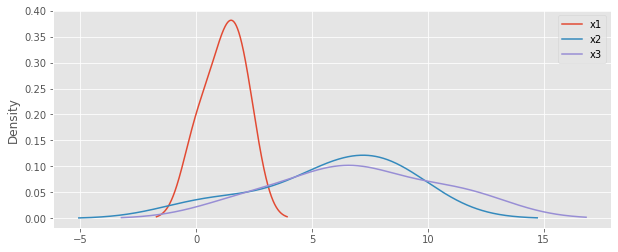

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(10, 4))

df = pd.DataFrame(data, columns=['x1', 'x2', 'x3'])
df.plot.kde(ax=ax)

_ = ax.legend()

In [75]:
from scipy.stats import multivariate_normal

# marginal PDFs
d1 = multivariate_normal(means[0], cov[0, 0])
d2 = multivariate_normal(means[1], cov[1, 1])
d3 = multivariate_normal(means[2], cov[2, 2])

# joint PDFs
jd12 = multivariate_normal(means[[0, 1]], cov[[0, 1]][:, [0, 1]])
jd13 = multivariate_normal(means[[0, 2]], cov[[0, 2]][:, [0, 2]])
jd23 = multivariate_normal(means[[1, 2]], cov[[1, 2]][:, [1, 2]])

In [76]:
x1_vals = np.linspace(x1.min(), x1.max(), num=100, endpoint=True)
x2_vals = np.linspace(x2.min(), x2.max(), num=100, endpoint=True)
x3_vals = np.linspace(x3.min(), x3.max(), num=100, endpoint=True)

print(len(x1_vals), len(x2_vals), len(x3_vals))

100 100 100


In [77]:
import itertools
# x1 and X2
triplets = ((jd12.pdf(tup), d1.pdf(tup[0]), d2.pdf(tup[1])) for tup in itertools.product(*[x1_vals, x2_vals]))
np.sum([p_xy * (np.log(p_xy) - np.log(p_x) - np.log(p_y)) for p_xy, p_x, p_y in triplets])

394.3706103509655

In [78]:
# x1 and X3
triplets = ((jd13.pdf(tup), d1.pdf(tup[0]), d3.pdf(tup[1])) for tup in itertools.product(*[x1_vals, x3_vals]))
np.sum([p_xy * (np.log(p_xy) - np.log(p_x) - np.log(p_y)) for p_xy, p_x, p_y in triplets])

3.49817190334607

In [79]:
# X2 and X3
triplets = ((jd23.pdf(tup), d2.pdf(tup[0]), d3.pdf(tup[1])) for tup in itertools.product(*[x2_vals, x3_vals]))
np.sum([p_xy * (np.log(p_xy) - np.log(p_x) - np.log(p_y)) for p_xy, p_x, p_y in triplets])

0.8399862719286941

In [81]:
# values1 = np.array([0.5, 1, 0.5, 0  , 0, 0  , 0, 0,0])
# values2 = np.array([0  , 0, 0  , 0.5, 1, 0.5, 0, 0,0])

In [48]:
import os
import numpy as np 

import torch
import torch.nn as nn

# import skimage.io
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms

from sklearn.metrics import normalized_mutual_info_score


class MutualInformation(nn.Module):

    def __init__(self, sigma=0.1, num_bins=256, normalize=True):
        super(MutualInformation, self).__init__()

        self.sigma = sigma
        self.num_bins = num_bins
        self.normalize = normalize
        self.epsilon = 1e-10

        self.bins = nn.Parameter(torch.linspace(0, 1, num_bins, device=device).float(), requires_grad=False)

    def marginalPdf(self, values):

        residuals = values - self.bins #.unsqueeze(0).unsqueeze(0)
        kernel_values = torch.exp(-0.5*(residuals / self.sigma).pow(2))

        pdf = torch.mean(kernel_values, dim=1)
        normalization = torch.sum(pdf, dim=0) + self.epsilon
        pdf = pdf / normalization

        return pdf, kernel_values

    def jointPdf(self, kernel_values1, kernel_values2):

        joint_kernel_values = torch.matmul(kernel_values1.transpose(1, 2), kernel_values2) 
        normalization = torch.sum(joint_kernel_values, dim=(1,2)).view(-1, 1, 1) + self.epsilon
        pdf = joint_kernel_values / normalization

        return pdf

    def getMutualInformation(self, input1, input2):
        '''
            input1: B, C, H, W
            input2: B, C, H, W

            return: scalar
        '''

        # Torch tensors for images between (0, 1)
#         input1 = input1*255
#         input2 = input2*255

#         B, C, H, W = input1.shape
#         assert((input1.shape == input2.shape))

#         x1 = input1.view(B, H*W, C)
#         x2 = input2.view(B, H*W, C)
        

        pdf_x1, kernel_values1 = self.marginalPdf(input1)
#         pdf_x2, kernel_values2 = self.marginalPdf(input2)
#         pdf_x1x2 = self.jointPdf(kernel_values1, kernel_values2)

#         H_x1 = -torch.sum(pdf_x1*torch.log2(pdf_x1 + self.epsilon), dim=1)
#         H_x2 = -torch.sum(pdf_x2*torch.log2(pdf_x2 + self.epsilon), dim=1)
#         H_x1x2 = -torch.sum(pdf_x1x2*torch.log2(pdf_x1x2 + self.epsilon), dim=(1,2))

#         mutual_information = H_x1 + H_x2 - H_x1x2

#         if self.normalize:
#             mutual_information = 2*mutual_information/(H_x1+H_x2)

#         return mutual_information

    def forward(self, input1, input2):
        '''
            input1: B, C, H, W
            input2: B, C, H, W

            return: scalar
        '''
        return self.getMutualInformation(input1, input2)



# if __name__ == '__main__':

#     device = 'cpu'

#     ### Create test cases ###
# #     img1 = Image.open('grad.jpg').convert('L')
# #     img2 = img1.rotate(10)

# #     arr1 = np.array(img1)
# #     arr2 = np.array(img2)

#     mi_true_1 = normalized_mutual_info_score(values1, values1)
#     mi_true_2 = normalized_mutual_info_score(values2, values2)

#     img1 = transforms.ToTensor() (img1).unsqueeze(dim=0).to(device)
#     img2 = transforms.ToTensor() (img2).unsqueeze(dim=0).to(device)

#     # Pair of different images, pair of same images
#     input1 = torch.cat([img1, img2])
#     input2 = torch.cat([img2, img2])

    

#     mi_test_1 = mi_test[0].cpu().numpy()
#     mi_test_2 = mi_test[1].cpu().numpy()

#     print('Image Pair 1 | sklearn MI: {}, this MI: {}'.format(mi_true_1, mi_test_1))
#     print('Image Pair 2 | sklearn MI: {}, this MI: {}'.format(mi_true_2, mi_test_2))

#     assert(np.abs(mi_test_1 - mi_true_1) < 0.05)
#     assert(np.abs(mi_test_2 - mi_true_2) < 0.05)

In [49]:
MI = MutualInformation(num_bins=128, sigma=0.1, normalize=True).to(device)
# mi_test = MI(values1, values2)

In [50]:
values1 = torch.Tensor(np.expand_dims(np.random.rand(128), axis=0))

In [51]:
values1.shape

torch.Size([1, 128])

In [52]:
pdf_x1, kernel_values1 = MI.marginalPdf(values1)

In [53]:
pdf_x1

tensor([1.])

In [32]:
 residuals = torch.Tensor(np.random.rand(128)) - MI.bins

In [33]:
residuals

tensor([ 0.8278,  0.1639,  0.1785,  0.6819,  0.3485,  0.3345,  0.3552,  0.9083,
         0.1181,  0.5284,  0.2619, -0.0493,  0.8409,  0.1621,  0.0155,  0.5363,
         0.7198,  0.7340,  0.3963,  0.7220,  0.4109,  0.3908, -0.0760,  0.0980,
        -0.1552,  0.7210,  0.5210,  0.1158,  0.7175,  0.1726,  0.2964,  0.1104,
        -0.2404,  0.3140, -0.0062, -0.0323, -0.1098,  0.0818,  0.2908, -0.1560,
         0.1668,  0.0644,  0.2533,  0.3859, -0.0768,  0.0796,  0.3341,  0.2856,
         0.1213,  0.1830,  0.1340,  0.3472, -0.1011, -0.2193,  0.4479, -0.4123,
         0.3070,  0.0503,  0.0047, -0.3552,  0.1070,  0.0171,  0.0234, -0.0300,
         0.0062,  0.2516,  0.1059,  0.3219, -0.2370,  0.4442, -0.1247, -0.3405,
        -0.4074, -0.3714, -0.1972, -0.3810, -0.0354, -0.4055, -0.1022,  0.3308,
        -0.6187, -0.3682, -0.1425, -0.2006,  0.1941,  0.0229,  0.0700, -0.5826,
         0.0935,  0.1701, -0.0561, -0.5208, -0.2593,  0.1190, -0.4561, -0.2596,
         0.1460, -0.0159, -0.1068, -0.54